In [185]:
import numpy as np
import pandas as pd
import SpaGCN as spg
import scipy.sparse as sp
import anndata as ad
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import seaborn as sns
import scanpy as sc
from paste2 import PASTE2, projection

# Load the Visium data
adata = sc.read_visium(
    '/content/15673/',
    count_file='filtered_feature_bc_matrix.h5',
    load_images=True
)
adata.var_names_make_unique()  # Make variable names unique


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [186]:
from scanpy import read_10x_h5


adata = read_10x_h5("/content/15673/filtered_feature_bc_matrix.h5")
spatial=pd.read_csv("/content/15673/spatial/tissue_positions_list.csv",sep=",",header=None,na_filter=False,index_col=0)

adata.obs["in_tissue"]=spatial[1]
adata.obs["array_row"]=spatial[2]
adata.obs["array_col"]=spatial[3]
adata.obs["imagerow"]=spatial[4]
adata.obs["imagecol"]=spatial[5]

adata=adata[adata.obs["in_tissue"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")


# Calculate the total counts and log-transform
adata.obs['total_counts'] = adata.X.sum(axis=1).A1  # Total counts per cell
adata.obs['log1p_total_counts'] = sc.pp.log1p(adata.obs['total_counts'], copy=True)  # Log-transformed total counts

# Calculate the number of genes by counts
adata.obs['n_genes_by_counts'] = (adata.X > 0).sum(1).A1  # Number of genes with non-zero counts
adata.obs['log1p_n_genes_by_counts'] = sc.pp.log1p(adata.obs['n_genes_by_counts'], copy=True)

# Calculate metrics for genes
adata.var['n_cells_by_counts'] = (adata.X > 0).sum(0).A1  # Number of cells expressing each gene
adata.var['mean_counts'] = adata.X.mean(axis=0).A1  # Mean counts per gene
adata.var['log1p_mean_counts'] = sc.pp.log1p(adata.var['mean_counts'], copy=True)


if sp.issparse(adata.X):
    # Ensure the data is treated as a sparse matrix for summing
    adata.obs['total_counts'] = np.array(adata.X.sum(axis=1)).flatten()
else:
    adata.obs['total_counts'] = adata.X.sum(axis=1)

# Now let's redo the function for calculating percentage counts for top genes
def pct_counts_in_top_genes(adata, n_top_genes):
    sum_axis_0 = np.array(adata.X.sum(axis=0)).flatten() if sp.issparse(adata.X) else adata.X.sum(axis=0)

    top_genes_indices = np.argsort(sum_axis_0)[::-1][:n_top_genes]
    top_gene_matrix = adata[:, top_genes_indices].X
    top_gene_counts = np.array(top_gene_matrix.sum(axis=1)).flatten() if sp.issparse(top_gene_matrix) else top_gene_matrix.sum(axis=1)

    total_counts = adata.obs['total_counts']


    pct_counts = np.zeros_like(total_counts)
    nonzero = total_counts > 0
    pct_counts[nonzero] = (top_gene_counts[nonzero] / total_counts[nonzero]) * 100

    return pct_counts

# Apply the function and update AnnData observation dataframe
adata.obs['pct_counts_in_top_50_genes'] = pct_counts_in_top_genes(adata, 50)
adata.obs['pct_counts_in_top_100_genes'] = pct_counts_in_top_genes(adata, 100)
adata.obs['pct_counts_in_top_200_genes'] = pct_counts_in_top_genes(adata, 200)
adata.obs['pct_counts_in_top_500_genes'] = pct_counts_in_top_genes(adata, 500)

adata.write_h5ad("/content/15673/data.h5ad")

adata = sc.read("/content/15673/data.h5ad")
img=cv2.imread("/content/15673/spatial/tissue_hires_image.png")



/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [187]:
#Set coordinates
x_array=adata.obs["array_row"].tolist()
y_array=adata.obs["array_col"].tolist()
x_pixel=adata.obs["imagerow"].tolist()
y_pixel=adata.obs["imagecol"].tolist()

#Test coordinates on the image
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-20):int(x+20), int(y-20):int(y+20),:]=0

cv2.imwrite('/content/15673/mapping.jpg', img_new)

True

In [188]:
s=1
b=49
#adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SpaGCN can calculate the adjacent matrix using the fnction below
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
np.savetxt('/content/15673/adj.csv', adj, delimiter=',')

Calculateing adj matrix using xy only...


In [189]:
adata=sc.read("/content/15673/data.h5ad")
adj=np.loadtxt('/content/15673/adj.csv', delimiter=',')
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [190]:
p=0.5
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 304.12201744612213]
Run 2: l [0.01, 500.005], p [0.0, 83.85807659348846]
Run 3: l [0.01, 250.0075], p [0.0, 21.34114436831361]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.750619747568681]
Run 5: l [0.01, 62.509375], p [0.0, 0.5111031977572873]
Run 6: l [31.2596875, 62.509375], p [0.00033941474562015905, 0.5111031977572873]
Run 7: l [46.884531249999995, 62.509375], p [0.07618062809320492, 0.5111031977572873]
Run 8: l [54.69695312499999, 62.509375], p [0.2408340503002373, 0.5111031977572873]
Run 9: l [58.6031640625, 62.509375], p [0.3638374517377281, 0.5111031977572873]
Run 10: l [60.556269531249995, 62.509375], p [0.4346341140578587, 0.5111031977572873]
Run 11: l [61.532822265625, 62.509375], p [0.4721853648227945, 0.5111031977572873]
recommended l =  62.021098632812496


In [191]:
#For this toy data, we set the number of clusters=7 since this tissue has 7 layers
n_clusters=7
#Set seed
r_seed=t_seed=n_seed=100
#Search for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  7
recommended res =  0.7


In [192]:
import random
import torch
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["layer_guess_reordered_short"]=refined_pred
adata.obs["layer_guess_reordered_short"]=adata.obs["layer_guess_reordered_short"].astype('category')
#Save results
adata.write_h5ad("/content/15673/results.h5ad")

Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
Epoch  90
Epoch  100
Epoch  110
Epoch  120
Epoch  130
Epoch  140
Epoch  150
Epoch  160
Epoch  170
Epoch  180
Epoch  190
Calculateing adj matrix using xy only...


In [193]:
adata=sc.read("/content/15673/results.h5ad")
#adata.obs should contain two columns for x_pixel and y_pixel
#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains="pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="imagecol",y="imagerow",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("/content/15673/pred.png", dpi=600)
plt.close()

#Plot refined spatial domains
domains="layer_guess_reordered_short"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="imagecol",y="imagerow",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("/content/15673/refined_pred.png", dpi=600)
plt.close()

In [194]:
#identifying svgs
#Read in raw data
from scipy.sparse import issparse

raw=sc.read("/content/15673/data.h5ad")
raw.var_names_make_unique()
raw.obs["pred"]=adata.obs["pred"].astype('category')
raw.obs["array_row"]=raw.obs["array_row"]
raw.obs["array_col"]=raw.obs["array_col"]
raw.obs["imagerow"]=raw.obs["imagerow"]
raw.obs["imagecol"]=raw.obs["imagecol"]
#Convert sparse matrix to non-sparse
raw.X=(raw.X.A if issparse(raw.X) else raw.X)
#raw.raw=raw
sc.pp.log1p(raw)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [195]:
target=0
#Set filtering criterials
min_in_group_fraction=0.8
min_in_out_group_ratio=1
min_fold_change=1.5
#Search radius such that each spot in the target domain has approximately 10 neighbors on average
adj_2d=spg.calculate_adj_matrix(x=x_array, y=y_array, histology=False)
start, end= np.quantile(adj_2d[adj_2d!=0],q=0.001), np.quantile(adj_2d[adj_2d!=0],q=0.1)
r=spg.search_radius(target_cluster=target, cell_id=adata.obs.index.tolist(), x=x_array, y=y_array, pred=adata.obs["pred"].tolist(), start=start, end=end, num_min=10, num_max=14,  max_run=100)
#Detect neighboring domains
nbr_domians=spg.find_neighbor_clusters(target_cluster=target,
                                   cell_id=raw.obs.index.tolist(),
                                   x=raw.obs["array_row"].tolist(),
                                   y=raw.obs["array_col"].tolist(),
                                   pred=raw.obs["pred"].tolist(),
                                   radius=r,
                                   ratio=1/2)

nbr_domians=nbr_domians[0:3]
de_genes_info=spg.rank_genes_groups(input_adata=raw,
                                target_cluster=target,
                                nbr_list=nbr_domians,
                                label_col="pred",
                                adj_nbr=True,
                                log=True)
#Filter genes
de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
filtered_info=de_genes_info
filtered_info=filtered_info[(filtered_info["pvals_adj"]<0.05) &
                            (filtered_info["in_out_group_ratio"]>min_in_out_group_ratio) &
                            (filtered_info["in_group_fraction"]>min_in_group_fraction) &
                            (filtered_info["fold_change"]>min_fold_change)]
filtered_info=filtered_info.sort_values(by="in_group_fraction", ascending=False)
filtered_info["target_dmain"]=target
filtered_info["neighbors"]=str(nbr_domians)
print("SVGs for domain ", str(target),":", filtered_info["genes"].tolist())

Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Run 1: radius [1.4142135381698608, 16.970561981201172], num_nbr [1.0, 354.5674846625767]
Calculateing adj matrix using xy only...
Run 2: radius [1.4142135381698608, 9.192387759685516], num_nbr [1.0, 121.93251533742331]
Calculateing adj matrix using xy only...
Run 3: radius [1.4142135381698608, 5.303300648927689], num_nbr [1.0, 42.059815950920246]
Calculateing adj matrix using xy only...
Run 4: radius [1.4142135381698608, 3.3587570935487747], num_nbr [1.0, 20.029141104294478]
Calculateing adj matrix using xy only...
Run 5: radius [2.386485315859318, 3.3587570935487747], num_nbr [8.733128834355828, 20.029141104294478]
Calculateing adj matrix using xy only...
recommended radius =  2.8726212047040462 num_nbr=12.501533742331288
radius= 2.8726212047040462 average number of neighbors for each spot is 12.501533742331288
 Cluster 0 has neighbors:
No neighbor domain found, o

In [196]:
adata

AnnData object with n_obs × n_vars = 3639 × 19130
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'total_counts', 'log1p_total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'pred', 'layer_guess_reordered_short'
    var: 'gene_ids', 'feature_types', 'genome', 'genename', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts'
    uns: 'log1p', 'pred_colors', 'layer_guess_reordered_short_colors'

In [197]:
import scanpy as sc
import pandas as pd

# Assuming you have already loaded your `adata` object and it contains other data you want to preserve
# adata = sc.read('/content/15673/data.h5ad')  # Load only if not already loaded

# Load the spatial coordinates
spatial_file_path = '/content/15673/spatial/tissue_positions_list.csv'
spatial_data_df = pd.read_csv(spatial_file_path, header=None)

# Assuming column indices 4 and 5 are the correct spatial coordinates
spatial_coordinates = spatial_data_df.iloc[:, [4, 5]].values

# Create a DataFrame with barcodes as index
spatial_coords_df = pd.DataFrame(spatial_coordinates, index=spatial_data_df.iloc[:, 0], columns=['x_coords', 'y_coords'])

# Ensure that the order of barcodes in spatial_coords_df matches the order in adata.obs_names
# Convert the DataFrame to an array in the same order as adata.obs_names
if set(adata.obs_names).issubset(set(spatial_coords_df.index)):
    aligned_spatial_data = spatial_coords_df.loc[adata.obs_names].values
    # Assign this array to adata.obsm without overwriting other keys
    adata.obsm['spatial'] = aligned_spatial_data
else:
    print("Error: Barcode mismatch or some barcodes are missing in the spatial data.")

# Now, adata.obsm['spatial'] contains the new spatial data aligned with your AnnData observations,
# and all previous data in `adata` remains unchanged.


In [198]:
adata

AnnData object with n_obs × n_vars = 3639 × 19130
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'total_counts', 'log1p_total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'pred', 'layer_guess_reordered_short'
    var: 'gene_ids', 'feature_types', 'genome', 'genename', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts'
    uns: 'log1p', 'pred_colors', 'layer_guess_reordered_short_colors'
    obsm: 'spatial'

In [199]:
adata.write_h5ad('/content/15673/data.h5ad')

In [202]:
sliceA_filename = '/content/15670/data.h5ad'
sliceB_filename = '/content/15671/data.h5ad'
sliceC_filename = '/content/15672/data.h5ad'
sliceD_filename = '/content/15673/data.h5ad'
sliceA = sc.read_h5ad(sliceA_filename)
sliceB = sc.read_h5ad(sliceB_filename)
sliceC = sc.read_h5ad(sliceC_filename)
sliceD = sc.read_h5ad(sliceD_filename)

/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:956: UserWarnin

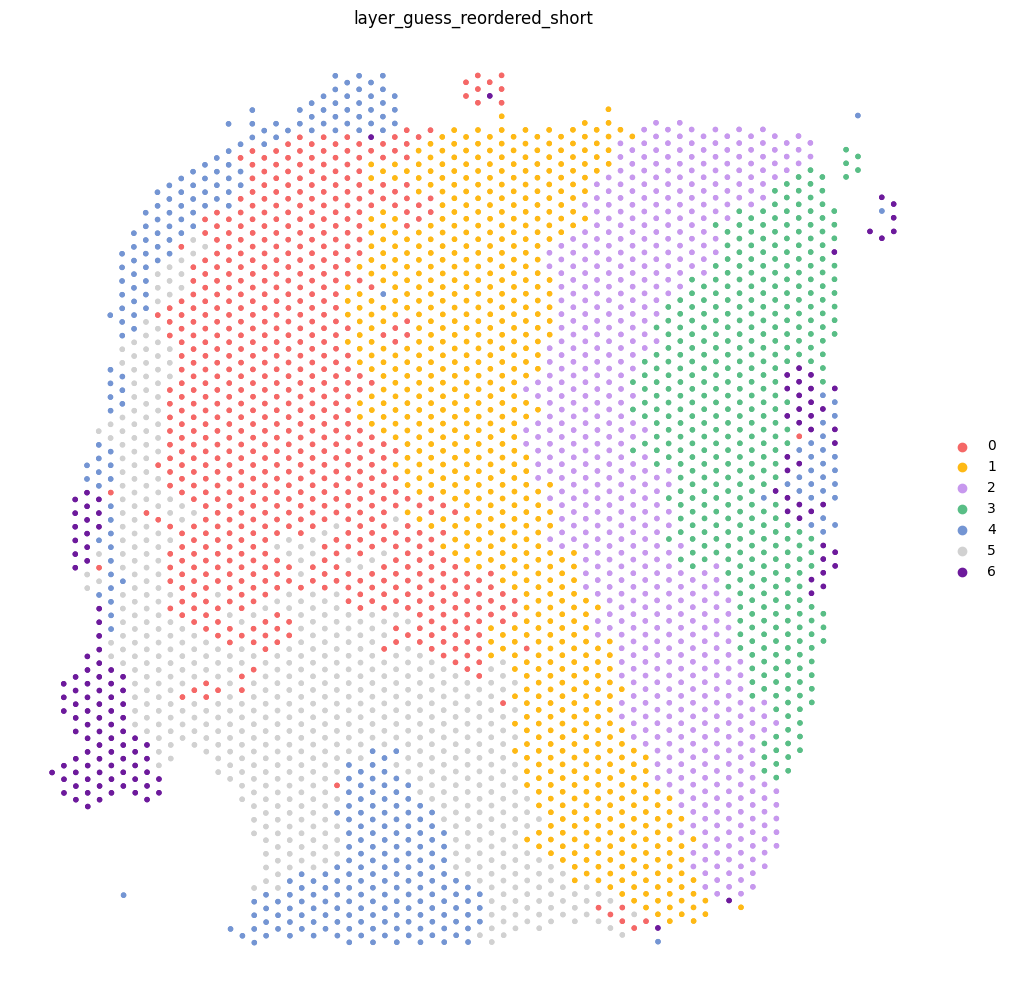

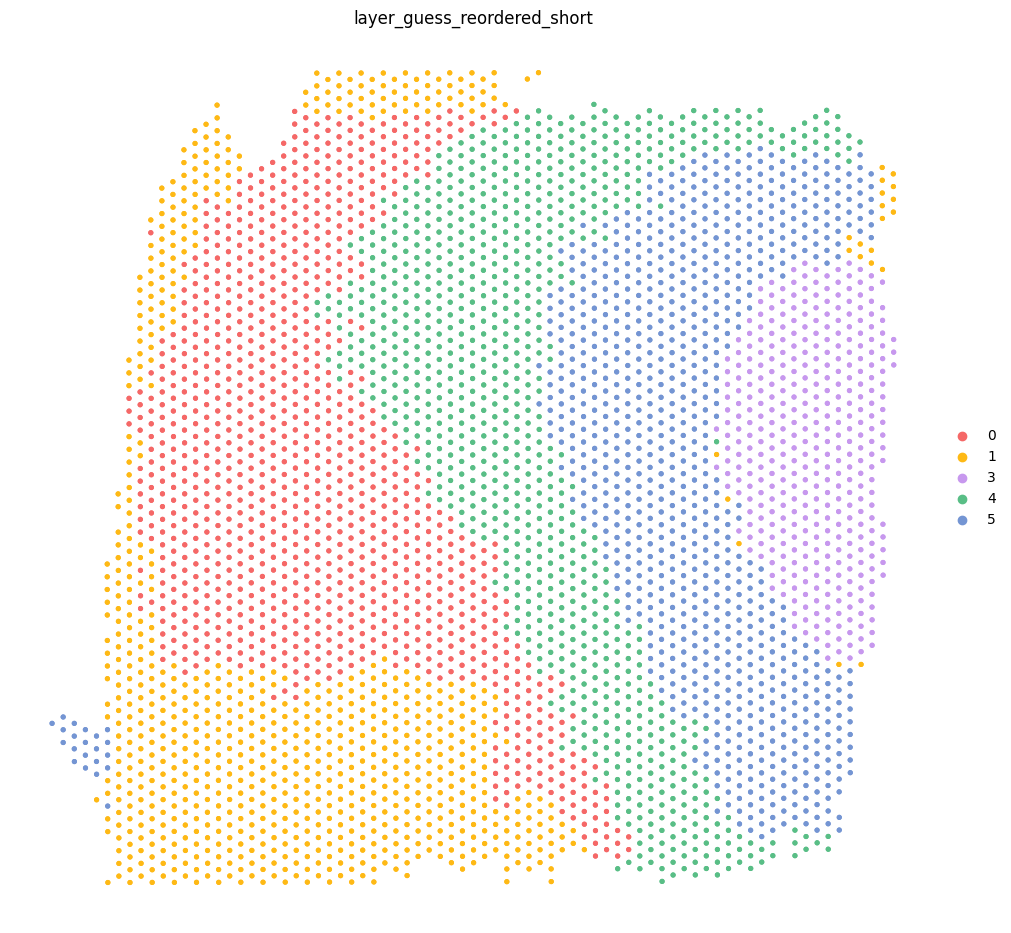

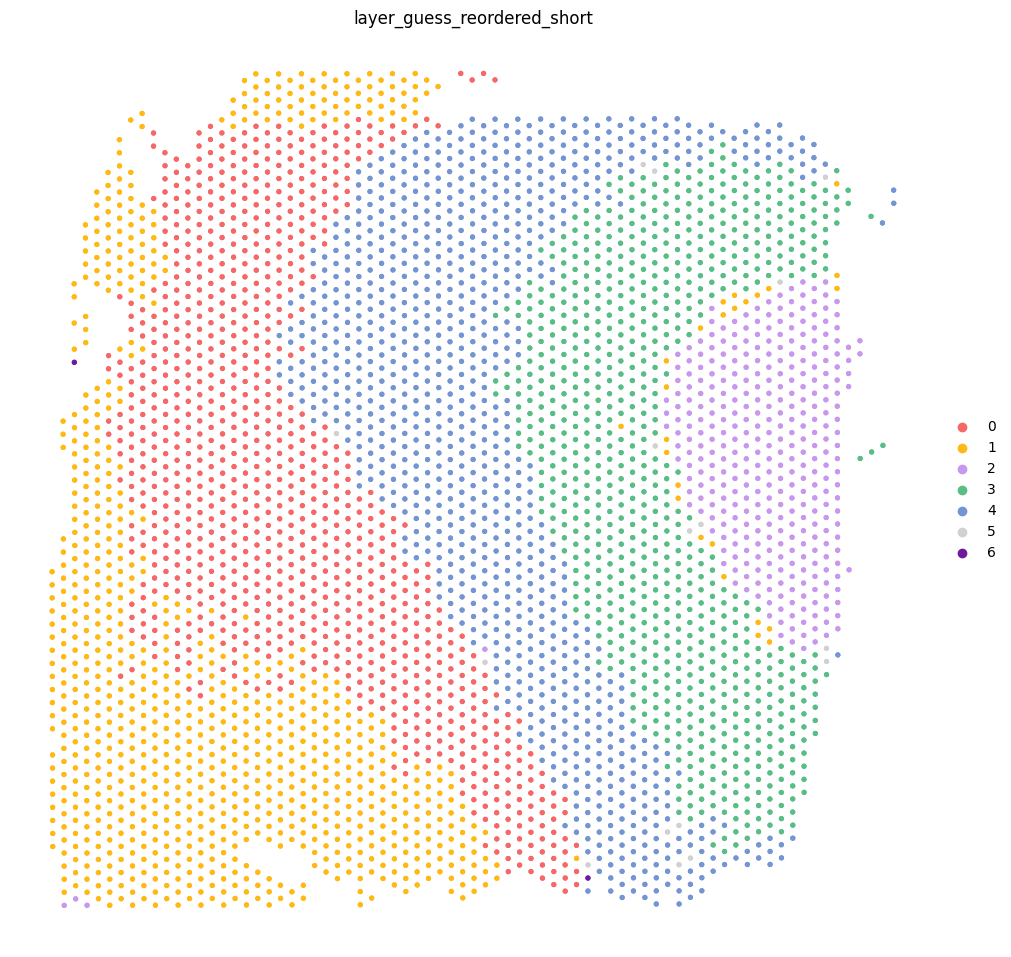

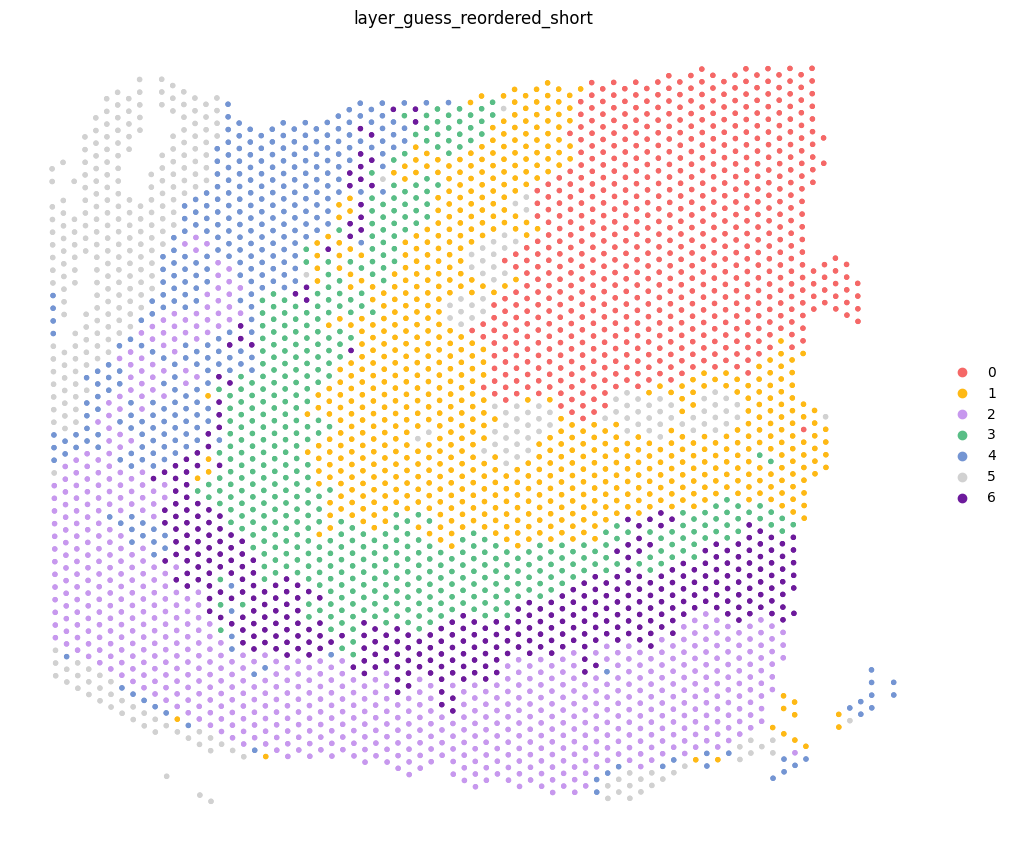

In [203]:
sq.pl.spatial_scatter(
    sliceA,
    frameon=False,
    shape=None,
    color='layer_guess_reordered_short',
    figsize=(10, 10)
)
sq.pl.spatial_scatter(
    sliceB,
    frameon=False,
    shape=None,
    color='layer_guess_reordered_short',
    figsize=(10, 10)
)
sq.pl.spatial_scatter(
    sliceC,
    frameon=False,
    shape=None,
    color='layer_guess_reordered_short',
    figsize=(10, 10)
)
sq.pl.spatial_scatter(
    sliceD,
    frameon=False,
    shape=None,
    color='layer_guess_reordered_short',
    figsize=(10, 10)
)

In [ ]:
pi_AB = PASTE2.partial_pairwise_align(sliceA, sliceB, s=0.7)

PASTE2 starts...
Starting GLM-PCA...
Iteration: 0 | deviance=8.4778E+6
Iteration: 1 | deviance=8.4778E+6
Iteration: 2 | deviance=8.3502E+6
Iteration: 3 | deviance=8.0072E+6
Iteration: 4 | deviance=7.8986E+6
Iteration: 5 | deviance=7.8549E+6
Iteration: 6 | deviance=7.8302E+6
Iteration: 7 | deviance=7.8137E+6
Iteration: 8 | deviance=7.8017E+6
Iteration: 9 | deviance=7.7925E+6
Iteration: 10 | deviance=7.7852E+6
Iteration: 11 | deviance=7.7792E+6
Iteration: 12 | deviance=7.7742E+6
Iteration: 13 | deviance=7.7700E+6
Iteration: 14 | deviance=7.7663E+6
Iteration: 15 | deviance=7.7631E+6
Iteration: 16 | deviance=7.7603E+6
Iteration: 17 | deviance=7.7577E+6
Iteration: 18 | deviance=7.7554E+6
Iteration: 19 | deviance=7.7533E+6
Iteration: 20 | deviance=7.7514E+6
Iteration: 21 | deviance=7.7497E+6
Iteration: 22 | deviance=7.7481E+6
Iteration: 23 | deviance=7.7466E+6
Iteration: 24 | deviance=7.7453E+6
Iteration: 25 | deviance=7.7440E+6
Iteration: 26 | deviance=7.7428E+6
Iteration: 27 | deviance=7.7

In [ ]:
pi_BC = PASTE2.partial_pairwise_align(sliceB, sliceC, s=0.7)

In [ ]:
pi_CD = PASTE2.partial_pairwise_align(sliceC, sliceD, s=0.7)